# Objectif du projet


Analyser les Discours du Trône (1911–2012)

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns



import spacy
from collections import Counter
from wordcloud import WordCloud


# modelisation 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation



from pathlib import Path


# modèle linguistique anglais
nlp = spacy.load("en_core_web_sm") 
nlp.max_length = 2_000_000 

## I.  Chargement et exploration des données

In [132]:
data_path = Path.cwd().parent / "data"  # chemin pour récuperer les données


df = pd.read_excel( data_path /  "Speech_Throne_1911_2012_2.xlsx")
df.head()


,Speech_Year,Date,Text
0,1,1911-02-06,"My Lords, and Gentlemen, In opening the first ..."
1,2,1912-02-14,"My Lords, and Gentlemen, My relations with for..."
2,3,1913-03-10,"My Lords, and Gentlemen, To-day being the fift..."
3,4,1914-11-11,"My Lords, and Gentlemen, The energies and symp..."
4,5,1916-02-15,"My Lords, and Gentlemen, It has been My duty t..."


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Speech_Year  105 non-null    int64         
 1   Date         105 non-null    datetime64[ns]
 2   Text         105 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.6+ KB


df['Text'] contient 105 discours (un par ligne)

In [134]:
df.iloc[0]['Text'] #premier discour 

'My Lords, and Gentlemen, In opening the first Parliament elected in My reign, the grievous loss which the Empire has sustained by the death of My beloved Father is upper most in My thoughts. When, a year ago, He addressed you from the Throne no one could have foreseen that His life of unceasing and devoted activity in the service of His subjects was so soon to be cut short. Bowing to the inscrutable decree of Providence, I take courage from His example, and I am sustained in My abiding sorrow by the sympathy extended to me by My people in every part of My Dominions. I have welcomed back My Uncle, the Duke of Connaught, on the completion of the Mission in South Africa, which I entrusted to him, and it has deeply gratified Me to learn that he was received with demonstrations of the utmost enthusiasm and loyalty in every part of My South African Dominions, and by every class of the community. I have welcomed back My Uncle, the Duke of Connaught, on the completion of the Mission in South 

**Vérification des valeurs manquantes**

In [135]:
df.isnull().sum() # Pas de valeurs manquantes

Speech_Year    0
Date           0
Text           0
dtype: int64

**Statistiques**

In [136]:
# longueur des discours
df['n_tokens'] = df['Text'].str.split().apply(len) # nombre de tokens 
df['n_chars'] = df['Text'].str.len()  # nombre total de caractères (lettres, espaces, ponctuation) dans chaque discours

print(df[['n_tokens', 'n_chars']].describe())


          n_tokens       n_chars
count   105.000000    105.000000
mean   1577.885714   9863.723810
std     591.495161   3760.059785
min      74.000000    402.000000
25%    1307.000000   8290.000000
50%    1610.000000   9939.000000
75%    1914.000000  11922.000000
max    3074.000000  19383.000000


D'apres les statistiques sur les discours, on peut voir que : 

Le nombre moyen de mots par discours : ~1578 tokens

Maximum : 3 074 tokens 
et le minimum : 74 tokens (cas exceptionnel, probablement un discours très court)

In [137]:
# les discours les plus courts
print("\nDiscours les plus courts :")
print(df.sort_values('n_tokens').head(3)[['Speech_Year', 'n_tokens', 'Text']])



Discours les plus courts :
    Speech_Year  n_tokens                                               Text
39           40        74  My Lords and Members of the House of Commons: ...
10           11       152  My Lords and Members of the House of Commons, ...
30           31       256  My Lords and Members of the House of Commons, ...


In [138]:
#  les discours les plus longs
print("\nDiscours les plus longs :")
print(df.sort_values('n_tokens', ascending=False).head(3)[['Speech_Year', 'n_tokens', 'Text']])



Discours les plus longs :
    Speech_Year  n_tokens                                               Text
71           72      3074  My Lords and Members of the House of Commons, ...
15           16      2897  My Lords and Members of the House of Commons, ...
7             8      2885  My Lords, and Gentlemen, The dissolution of th...


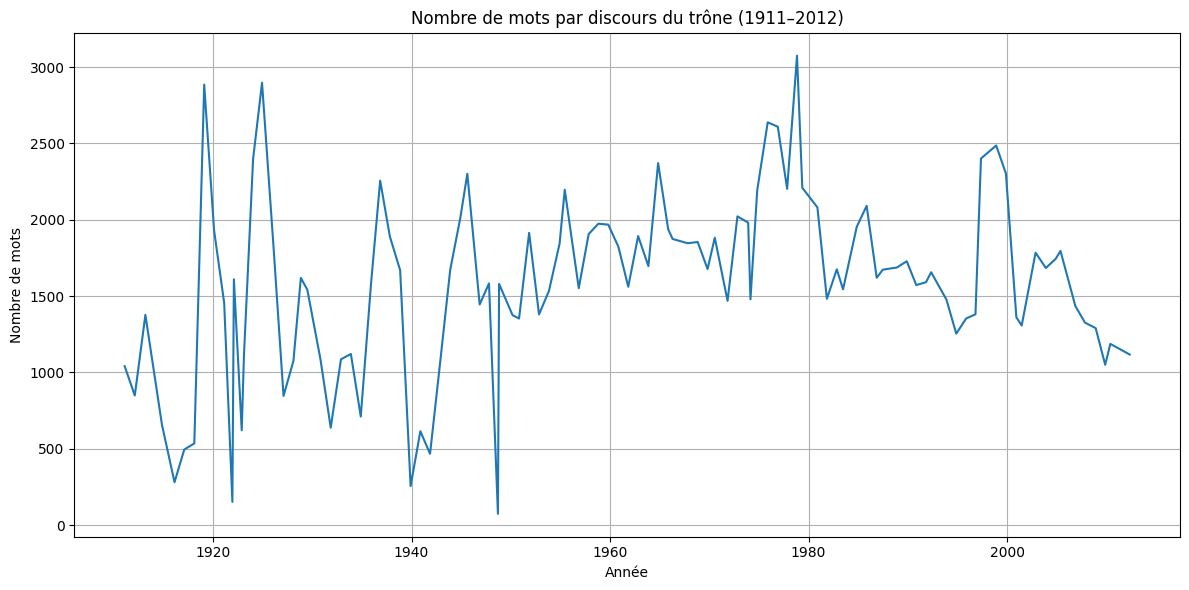

In [139]:
# nombre de mots pas discours et par an
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['n_tokens'])
plt.title("Nombre de mots par discours du trône (1911–2012)")
plt.xlabel("Année")
plt.ylabel("Nombre de mots")
plt.grid(True)
plt.tight_layout()
plt.show()

In [140]:
doc_complet = nlp(" ".join(df["Text"]).lower())  #  représente tout le corpus concaténé (donc 1 très long texte)
unique_words = set([token.text for token in doc_complet if token.is_alpha])
print(f"Mots différents dans tout le corpus : {len(unique_words)}")


Mots différents dans tout le corpus : 5210


## II. Nettoyage et prétraitement

In [141]:
# Fonction de prétraitement
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 2
    ]
    return " ".join(tokens)

# Appliquer à tout le corpus
df['clean_text'] = df['Text'].apply(preprocess)

Cette fonction effectue une "pipeline" en appliquant  les étapes  suivantes :

- Convertit le texte en minuscules

- Tokenise le texte (découpe en mots)

- Retire la ponctuation, les chiffres et les stop words (mots peu informatifs)

- Lemmatisation : réduit les mots à leur forme de base (ex. "running" en "run")

- Garde uniquement les mots alphabétiques de plus de 2 lettres

 Le résultat est une version "propre" du discours

## III. Analyse exploratoire (EDA)

**Analyse stop words les plus fréquents**

In [142]:
#stop words supprimés
stop_words_in_text = [token.text for token in doc_complet if token.is_stop]
# compter les fréquences de chaque stop word
freq_stop = Counter(stop_words_in_text)

# les 20 plus fréquents
print("Top 20 des stop words les plus fréquents :")
for word, count in freq_stop.most_common(200):
    print(f"{word:<10} {count}")

Top 20 des stop words les plus fréquents :
the        13491
of         9064
to         8800
and        8003
will       5354
in         4096
my         3111
for        2850
be         2752
a          2502
with       1499
on         1103
they       1055
their      831
that       806
by         804
you        778
which      771
i          565
before     543
are        525
have       477
an         472
at         467
our        467
other      459
this       429
is         415
further    395
's         388
all        379
as         375
from       333
it         328
also       302
make       285
has        255
may        246
those      246
been       237
more       237
its        237
between    225
full       225
give       218
upon       205
take       189
part       181
made       170
these      167
your       164
into       145
under      142
we         135
against    134
being      131
both       130
next       128
who        127
through    122
so         112
within     112
out        10

In [143]:
# Nombre total de tokens dans le texte
total_tokens = len([token for token in doc_complet if token.is_alpha])

# Nombre de stop words supprimés
n_stop_removed = len([token for token in doc_complet if token.is_alpha and token.is_stop])

print(f"Nombre total de mots : {total_tokens}")
print(f"Nombre de stop words supprimés : {n_stop_removed}")
print(f"Proportion supprimée : {n_stop_removed / total_tokens:.2%}")


Nombre total de mots : 166103
Nombre de stop words supprimés : 83819
Proportion supprimée : 50.46%


Le nombre de stop words supprimés est de 83,819 : cela signifie que plus de la moitié des mots du corpus sont considérés comme des stop words

**comparaison texte avant/après prétraitement**

In [144]:
original = df['Text'][0]
cleaned = preprocess(df['Text'][0])

print("Texte original :\n", original[:500])  # on limite à 500 caractères
print("\nTexte nettoyé :\n", cleaned[:500])


Texte original :
 My Lords, and Gentlemen, In opening the first Parliament elected in My reign, the grievous loss which the Empire has sustained by the death of My beloved Father is upper most in My thoughts. When, a year ago, He addressed you from the Throne no one could have foreseen that His life of unceasing and devoted activity in the service of His subjects was so soon to be cut short. Bowing to the inscrutable decree of Providence, I take courage from His example, and I am sustained in My abiding sorrow by

Texte nettoyé :
 lord gentleman open parliament elect reign grievous loss empire sustain death beloved father upper thought year ago address throne foresee life unceasing devoted activity service subject soon cut short bow inscrutable decree providence courage example sustain abide sorrow sympathy extend people dominion welcome uncle duke connaught completion mission south africa entrust deeply gratify learn receive demonstration utmost enthusiasm loyalty south african domini

**Analyse de fréquence des mots (hors stop words)**

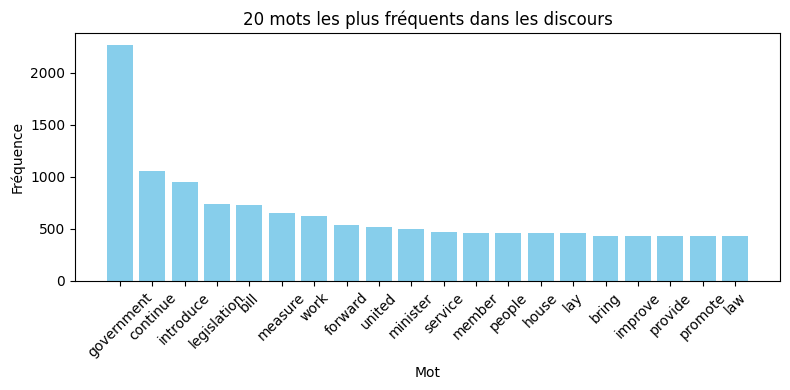

In [145]:
# Fusionner tous les discours nettoyés
corpus_clean = " ".join(df["clean_text"])

# Compter la fréquence des mots
word_freq = Counter(corpus_clean.split())

# Garder les 20 mots les plus fréquents
most_common = word_freq.most_common(20)

# Séparer les mots et leurs fréquences
words, freqs = zip(*most_common)

# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.bar(words, freqs, color='skyblue')
plt.title("20 mots les plus fréquents dans les discours")
plt.xlabel("Mot")
plt.ylabel("Fréquence")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Nuage de mots par période et monarque donnée**



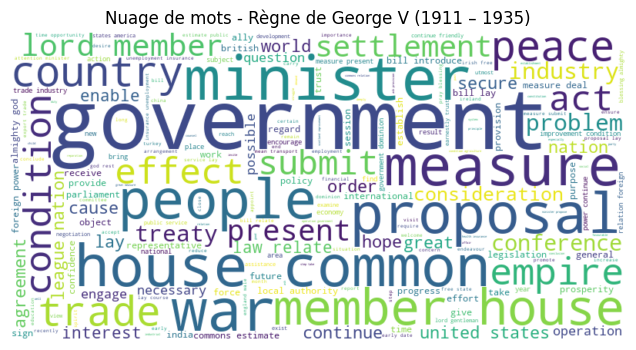

In [146]:

# Filtre les discours de George V (1911 – 1935)
df['Year'] = df['Date'].dt.year
df_george_v = df[df['Year'].between(1911, 1935)] 

#  textes nettoyés
text_g6 = " ".join(df_george_v["clean_text"])

# nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_g6)

# grahpique
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots - Règne de George V (1911 – 1935)")
plt.show()


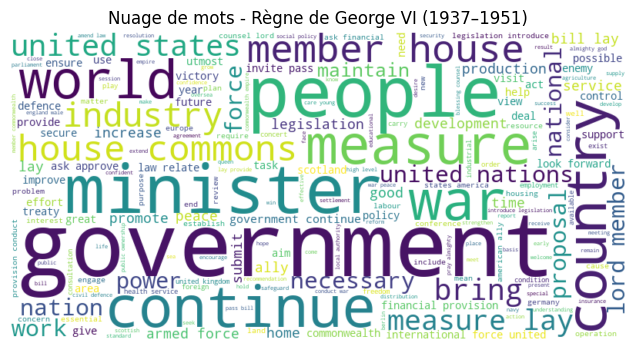

In [147]:

# Filtre les discours de George VI (1937 à 1951)
df['Year'] = df['Date'].dt.year
df_george_vi = df[df['Year'].between(1937, 1951)]

# Fusionner les textes nettoyés
text_g6 = " ".join(df_george_vi["clean_text"])

# nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_g6)

# graphique
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots - Règne de George VI (1937–1951)")
plt.show()


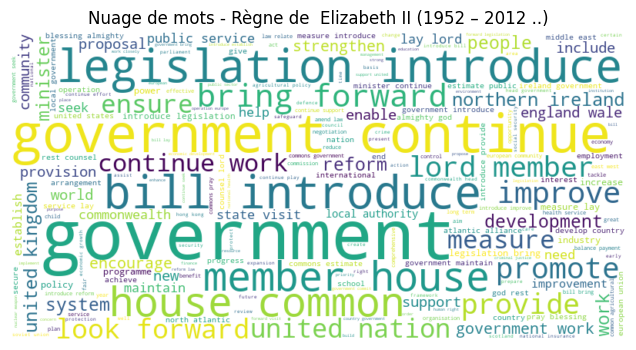

In [148]:

# Filtre les discours de Elizabeth II (1952 – 2012 ..)
df['Year'] = df['Date'].dt.year
df_elizabeth_ii = df[df['Year'].between(1952, 2012)]

#  textes nettoyés
text_g6 = " ".join(df_elizabeth_ii["clean_text"])

#  nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_g6)

# graphique
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots - Règne de  Elizabeth II (1952 – 2012 ..)")
plt.show()

## IV. Modélisation thématique avec LDA

### 1)  Vectorisation

On utilise CountVectirizer, en supprimant les mots trop fréquents (max_df=0.9), donc présents dans plus de 90% des discours, mais aussi on ignore les mots trop rares (min_df=10) → présents dans moins de 10 discours.

Ensuite on transforme la colonne clean_text en une matrice document-terme (DTM), où :

- chaque ligne = un discours

- chaque colonne = un mot

- chaque valeur = nombre de fois que le mot apparaît dans ce discours

In [149]:
cv = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = cv.fit_transform(df['clean_text'])

### 2) Entraînement du modèle LDA (Latent Dirichlet Allocation) 

In [150]:
lda = LatentDirichletAllocation(n_components=3, random_state=42) # pour 5 topics, choisi de manière arbitraire 
lda.fit(dtm)

LatentDirichletAllocation(n_components=3, random_state=42)

### 3) Exploration du vocabulaire

In [151]:
len(cv.get_feature_names_out()) # nombre total de mots uniques conservés après vectorisation

788

In [152]:
for i in range(10):
    random_word_id = random.randint(0, 788)
    print(cv.get_feature_names_out()[random_word_id])   # au hasard 10 mots 

effect
burden
settlement
good
kong
agency
foster
aspect
fight
stable


**Analyse d’un topic**

In [153]:
lda.components_   # matrice des poids : une ligne par topic, une colonne par mot

array([[ 6.47501297,  6.80546649, 20.7553669 , ..., 16.10493168,
        38.87141608, 13.47785372],
       [21.10640483,  1.34760176,  2.07073831, ..., 98.58304772,
        29.42740606, 14.31658417],
       [ 8.4185822 , 12.84693175, 11.17389479, ..., 55.3120206 ,
        19.70117786,  2.20556211]])

**Premier topic**

In [154]:
single_topic = lda.components_[0]  #  1er topic (index 0)
single_topic.argsort() # trié du moins important au plus important dans le topic


array([120, 328, 218, 191, 410,  17, 401, 244, 225, 299, 367, 192,  23,
        58, 224, 221, 353, 341, 508, 255, 184, 719, 112, 113, 313, 290,
       476, 230, 128, 337, 153, 740, 675, 586,  34, 430, 325, 690, 519,
       219, 373, 452, 390, 199, 198, 444, 310, 676, 733, 142, 680, 327,
        99,  68, 411, 138, 174, 123, 506, 188,  36, 438, 391, 288, 257,
       412, 100, 759, 348, 243, 700, 273, 145,  64,  39, 366, 711, 105,
       193, 141, 520, 308,   7,  43, 609, 597, 499, 320, 178, 464, 117,
       563, 535, 537, 509, 332, 258, 185, 542, 180, 765, 281, 674, 584,
       200, 721, 148, 579, 710, 441, 603,  44, 589, 315, 183, 742, 189,
       154, 204, 679, 510, 272, 379, 388, 638, 432, 380, 235, 556, 206,
       181, 409, 585, 614,  45, 628, 685, 417, 384,   3, 494, 350, 623,
       709, 122, 647, 723, 780, 167, 205, 392, 151,  55, 451, 591, 635,
       600,  80, 744,  67,  47, 488, 338, 592, 583, 196,  42, 429, 507,
         0, 626, 398, 119, 637, 746, 578,  77,  48,   1, 569, 14

In [155]:
top_ten_words = single_topic.argsort()[-10:]  # 10 indices des mots les plus importants du topic
for index in top_ten_words:
    print(cv.get_feature_names_out()[index])

seek
maintain
economic
promote
work
law
policy
united
legislation
introduce


### 4) Analyse de tous les topics

Comme nous l'avons vu, pour chaque topic, lda.components_ est une matrice de poids (topics × mots), pour la quelle on récupère les indices les plus importants du topic et on convertit ces ces indices en mots lisibles

In [156]:
# méthode classique pour interpréter manuellement les topics

#  top mots par topic
for idx, topic in enumerate(lda.components_):
    print(f"TOPIC {idx}:")
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')


TOPIC 0:
['provide', 'development', 'forward', 'improve', 'commonwealth', 'seek', 'maintain', 'economic', 'promote', 'work', 'law', 'policy', 'united', 'legislation', 'introduce']


TOPIC 1:
['provision', 'condition', 'provide', 'united', 'world', 'force', 'power', 'peace', 'proposal', 'country', 'industry', 'trade', 'people', 'war', 'minister']


TOPIC 2:
['include', 'provide', 'support', 'new', 'united', 'promote', 'people', 'public', 'improve', 'bring', 'reform', 'forward', 'legislation', 'work', 'introduce']




### 5) Attribution d’un topic dominant par document

Ensuite on transforme la matric dtm en une nouvelle matric de probabilités où :

- Chaque ligne = un document

- Chaque colonne = la probabilité d’appartenir à un topic



In [157]:
topic_results = lda.transform(dtm)  #  nouvelle matrice de probabilités
topic_results.shape  # dimensions nombre de documents et nombre de topics

(105, 3)

In [158]:
topic_results[0].round(2) # probabilités d’appartenance du premier discours aux 5 topics

array([0., 1., 0.])

In [159]:
topic_results[0].argmax() # topic le plus probable pour le premier discours

np.int64(1)

In [160]:
df['Topic'] = topic_results.argmax(axis=1) # colonne topic dans le dataFrame contenant le topic dominant attribué à chaque discours

In [161]:
df

,Speech_Year,Date,Text,n_tokens,n_chars,clean_text,Year,Topic
0,1,1911-02-06,"My Lords, and Gentlemen, In opening the first ...",1041,6384,lord gentleman open parliament elect reign gri...,1911,1
1,2,1912-02-14,"My Lords, and Gentlemen, My relations with for...",849,5072,lord gentleman relation foreign power continue...,1912,1
2,3,1913-03-10,"My Lords, and Gentlemen, To-day being the fift...",1377,8290,lord gentleman day fiftieth anniversary marria...,1913,1
3,4,1914-11-11,"My Lords, and Gentlemen, The energies and symp...",656,3833,lord gentleman energy sympathy subject empire ...,1914,1
4,5,1916-02-15,"My Lords, and Gentlemen, It has been My duty t...",281,1628,lord gentleman duty summon short recess renew ...,1916,1
...,...,...,...,...,...,...,...,...
100,101,2007-11-06,"My Lords and Members of the House of Commons, ...",1326,8663,lord member house commons government forward p...,2007,2
101,102,2008-12-03,"My Lords and Members of the House of Commons, ...",1290,8304,lord member house commons government override ...,2008,2
102,103,2009-11-18,"""My Lords and Members of the House of Commons,...",1050,6987,lord member house commons government override ...,2009,2
103,104,2010-05-25,"""My Lords and Members of the House of Commons,...",1187,7732,lord member house commons government legislati...,2010,2


## Choisir le bon nombre de topics 

Perplexities

n_topics = 2 → perplexity = 473.20
n_topics = 3 → perplexity = 461.71
n_topics = 4 → perplexity = 460.00
n_topics = 5 → perplexity = 455.01
n_topics = 6 → perplexity = 457.50
n_topics = 7 → perplexity = 461.00
n_topics = 8 → perplexity = 463.80
n_topics = 9 → perplexity = 466.59
n_topics = 10 → perplexity = 468.95


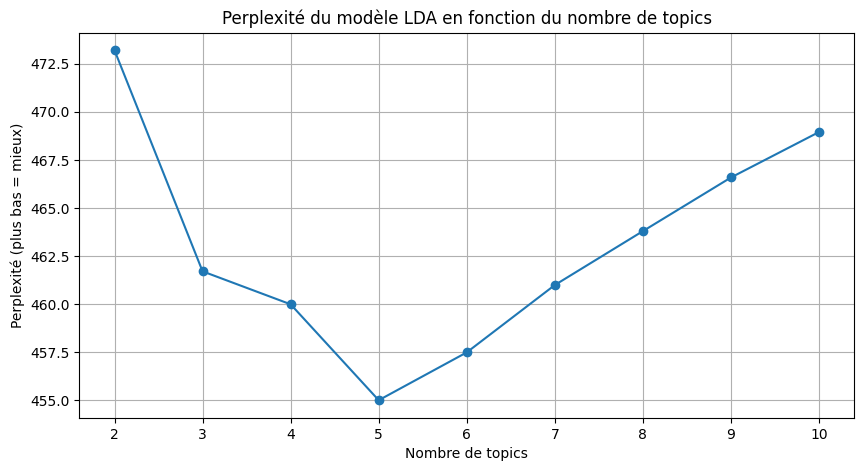

In [162]:
# Vectorisation du texte nettoyé (clean_text)
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(df['clean_text'])

# Liste des nombres de topics à tester
topic_numbers = [2, 3, 4, 5, 6, 7,  8, 9, 10]
perplexities = []

# Boucle sur chaque nombre de topics
for n in topic_numbers:
    lda = LatentDirichletAllocation(n_components=n, random_state=42)
    lda.fit(dtm)
    perplexity = lda.perplexity(dtm)
    perplexities.append(perplexity)
    print(f"n_topics = {n} → perplexity = {perplexity:.2f}")

# Tracer la courbe
plt.figure(figsize=(10, 5))
plt.plot(topic_numbers, perplexities, marker='o', linestyle='-')
plt.title("Perplexité du modèle LDA en fonction du nombre de topics")
plt.xlabel("Nombre de topics")
plt.ylabel("Perplexité (plus bas = mieux)")
plt.grid(True)
plt.show()

Le meilleur score de perplexité est atteint avec n=4, donc c’est le modèle statistiquement le plus performant sur notre corpus.

Cependant ceela ne garantit pas que les 4 topics sont bien interprétables. Il faut les examiner manuellement :

In [163]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

for i, topic in enumerate(lda.components_):
    print(f"\nTOPIC {i}")
    print([vectorizer.get_feature_names_out()[j] for j in topic.argsort()[-15:]])


TOPIC 0
['country', 'bring', 'increase', 'law', 'seek', 'industry', 'united', 'provide', 'promote', 'commonwealth', 'economic', 'development', 'minister', 'legislation', 'introduce']

TOPIC 1
['power', 'time', 'necessary', 'states', 'national', 'ask', 'minister', 'world', 'country', 'ally', 'peace', 'united', 'force', 'people', 'war']

TOPIC 2
['secure', 'united', 'ensure', 'include', 'provide', 'new', 'people', 'improve', 'public', 'bring', 'reform', 'legislation', 'forward', 'work', 'introduce']

TOPIC 3
['international', 'treaty', 'act', 'power', 'relate', 'present', 'law', 'deal', 'country', 'condition', 'proposal', 'improvement', 'industry', 'trade', 'minister']

TOPIC 4
['security', 'support', 'visit', 'promote', 'law', 'united', 'maintain', 'reform', 'improve', 'community', 'forward', 'policy', 'legislation', 'work', 'introduce']


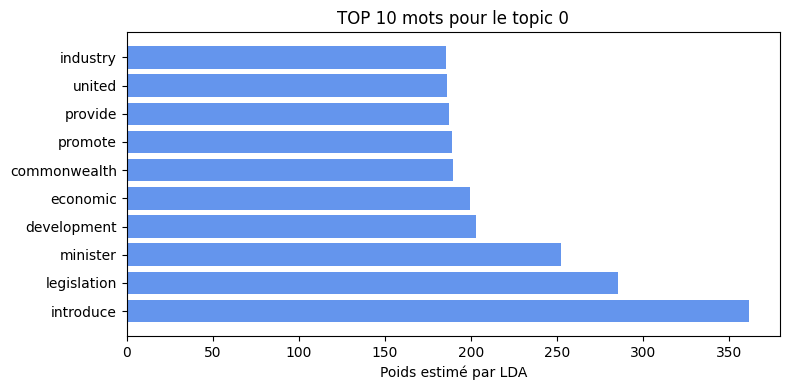

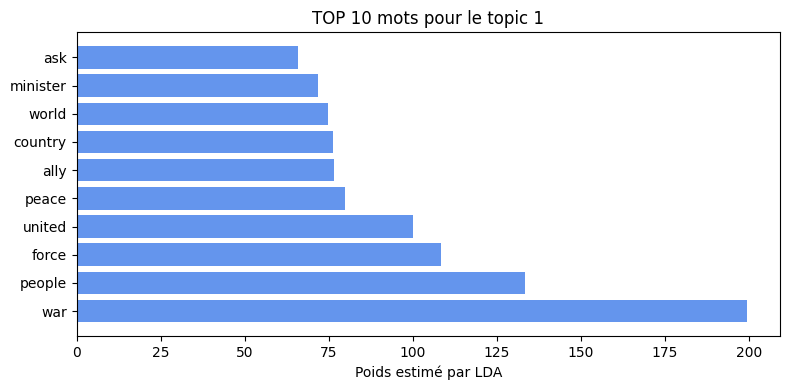

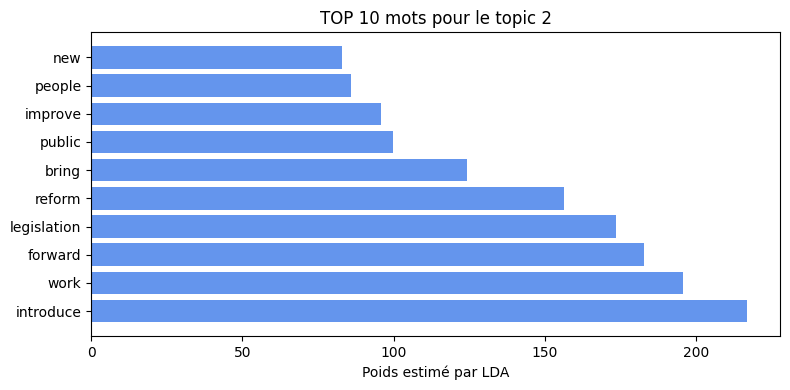

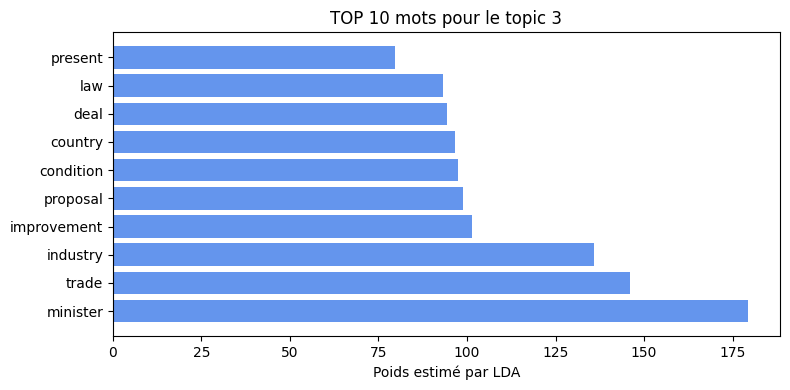

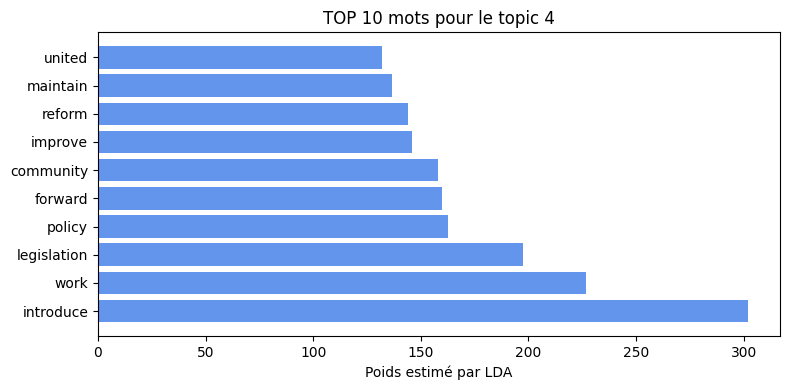

In [164]:

# Nombre de mots à afficher par topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

# Boucle sur chaque topic
for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-n_top_words:]
    top_words = [feature_names[i] for i in top_indices]
    top_values = topic[top_indices]
    
    plt.figure(figsize=(8, 4))
    plt.barh(top_words, top_values, color='cornflowerblue')
    plt.title(f"TOP {n_top_words} mots pour le topic {topic_idx}")
    plt.xlabel("Poids estimé par LDA")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# !!! à VOIR  !!! 



Exemple des sujets d'après les mots :

Topic ----- Nom interprété

0 ----- TOPIC 0 → Politique économique & législative

1 ----- TOPIC 1 → Guerre, diplomatie & alliances

2 ----- TOPIC 2 → Réformes sociales & services publics

3 ----- TOPIC 3 → Relations internationales & commerce

4 ------ TOPIC 4 → Sécurité intérieure & politiques sociales

### Matrice de probabilité 

In [165]:
topic_results = lda.transform(dtm)  #  nouvelle matrice de probabilités
topic_results.shape

(105, 5)

### Topic dominant à chaque discours



In [166]:
df['Topic'] = topic_results.argmax(axis=1)
df

,Speech_Year,Date,Text,n_tokens,n_chars,clean_text,Year,Topic
0,1,1911-02-06,"My Lords, and Gentlemen, In opening the first ...",1041,6384,lord gentleman open parliament elect reign gri...,1911,3
1,2,1912-02-14,"My Lords, and Gentlemen, My relations with for...",849,5072,lord gentleman relation foreign power continue...,1912,3
2,3,1913-03-10,"My Lords, and Gentlemen, To-day being the fift...",1377,8290,lord gentleman day fiftieth anniversary marria...,1913,3
3,4,1914-11-11,"My Lords, and Gentlemen, The energies and symp...",656,3833,lord gentleman energy sympathy subject empire ...,1914,1
4,5,1916-02-15,"My Lords, and Gentlemen, It has been My duty t...",281,1628,lord gentleman duty summon short recess renew ...,1916,1
...,...,...,...,...,...,...,...,...
100,101,2007-11-06,"My Lords and Members of the House of Commons, ...",1326,8663,lord member house commons government forward p...,2007,2
101,102,2008-12-03,"My Lords and Members of the House of Commons, ...",1290,8304,lord member house commons government override ...,2008,2
102,103,2009-11-18,"""My Lords and Members of the House of Commons,...",1050,6987,lord member house commons government override ...,2009,2
103,104,2010-05-25,"""My Lords and Members of the House of Commons,...",1187,7732,lord member house commons government legislati...,2010,2


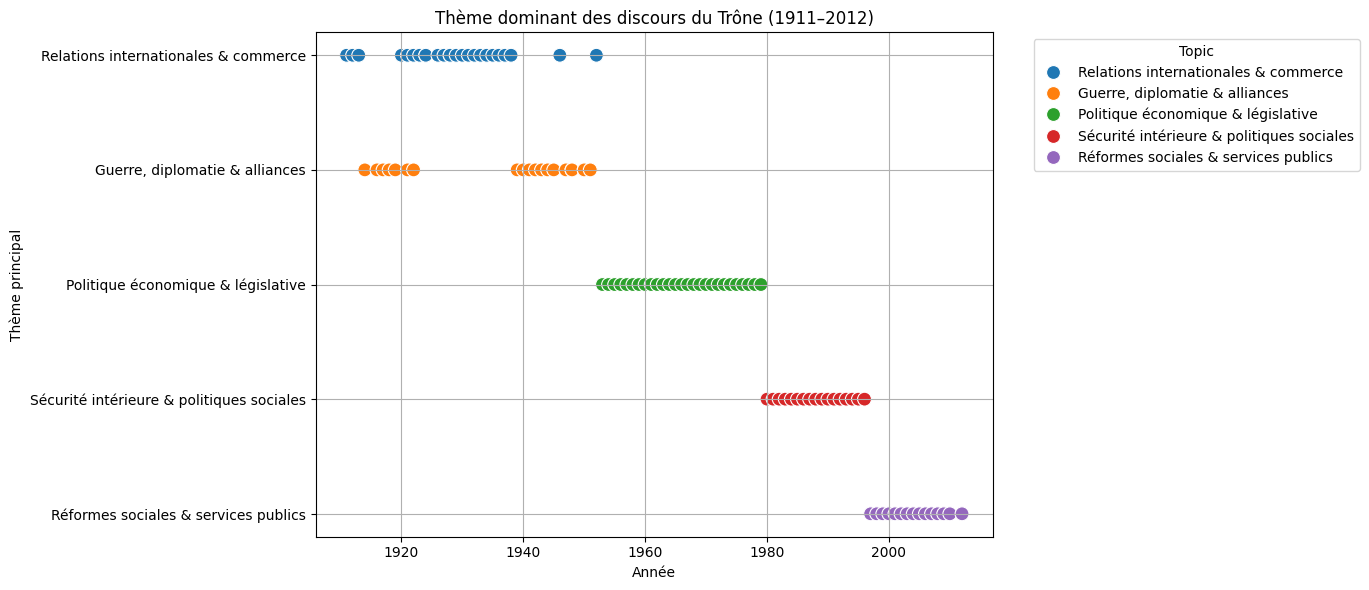

In [ ]:
# on cree un label pour mieux comprendre 'Topic_Label' 
topic_labels = {
    0: "Politique économique & législative",
    1: "Guerre, diplomatie & alliances",
    2: "Réformes sociales & services publics",
    3: "Relations internationales & commerce",
    4: "Sécurité intérieure & politiques sociales"

}


df['Topic_Label'] = df['Topic'].map(topic_labels)

# graphique 
plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='Year',
    y='Topic_Label',
    hue='Topic_Label',
    palette='tab10',
    data=df,
    s=100
)
plt.title("Thème dominant des discours du Trône (1911–2012)")
plt.xlabel("Année")
plt.ylabel("Thème principal")
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## V. Analyse de sentiment (optionnelle)